In [1]:
import numpy as np
from lib.dvr2d import *
from lib.utils import *
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, BOBYQA, NELDER_MEAD, SNOBFIT
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PrimitiveOp
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

%load_ext autoreload

ModuleNotFoundError: No module named 'dvr2d'

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter


theta1 = Parameter('X[0]')
a = QuantumCircuit(2)
a.ry(theta1, 0)
# print(a.)

theta2 = Parameter('X[0]')
b = QuantumCircuit(2)
b.ry(theta2, 0)

s = [str(a)]
print(str(b) in s)

True


In [2]:
r = []
costheta = []
v = []
with open('arhcl.txt', 'r') as f:
# with open('h63.txt', 'r') as f:
    lines = f.readlines()
    for l in lines:
        r.append(float(l[:22]))
        costheta.append(float(l[22:53]))
        v.append(float(l[53:-1]))

r = np.array(r)
costheta = np.array(costheta)
theta = np.arccos(costheta)
v = np.array(v)
print(v.shape)
# print(theta)
print(np.unique(r))
print(np.unique(theta))
print(np.unique(r)[130])

(202101,)
[ 3.      3.0065  3.013  ... 15.987  15.9935 16.    ]
[0.         0.20033484 0.28379411 0.34816602 0.40271584 0.45102681
 0.49493413 0.53552665 0.5735131  0.60938531 0.64350111 0.67613051
 0.70748321 0.73772597 0.76699401 0.79539883 0.82303369 0.84997757
 0.87629806 0.90205362 0.92729522 0.95206764 0.97641053 1.00035922
 1.02394538 1.04719755 1.07014161 1.09280113 1.11519765 1.13735101
 1.15927948 1.18100003 1.20252843 1.22387943 1.24506684 1.26610367
 1.28700222 1.30777412 1.32843048 1.34898186 1.36943841 1.38980988
 1.41010567 1.43033491 1.45050644 1.47062891 1.49071075 1.51076027
 1.53078565 1.55079499 1.57079633 1.59079766 1.610807   1.63083239
 1.65088191 1.67096375 1.69108621 1.71125774 1.73148698 1.75178278
 1.77215425 1.7926108  1.81316218 1.83381853 1.85459044 1.87548898
 1.89652581 1.91771322 1.93906422 1.96059262 1.98231317 2.00424165
 2.026395   2.04879153 2.07145104 2.0943951  2.11764728 2.14123344
 2.16518213 2.18952502 2.21429744 2.23953903 2.26529459 2.2916150

In [3]:
%autoreload
pot2d = interp_pot2d(r, costheta, v)

UsageError: Line magic function `%autoreload` not found.


In [4]:
%autoreload
N_R = 35
N_theta = 4
l = 1
K_max = 0
r_min = 3.4
r_max = 5

In [5]:
%autoreload
Rs_DVR, Xs_K = get_DVR_Rtheta(N_R, N_theta, 0, l=l, r_min=r_min, r_max=r_max)
Rs_angs = Rs_DVR * arhcl_params['S'] * au_to_angs
print(Rs_angs)
print(Rs_angs.shape)
N_R_lim = Rs_angs.shape[0]

[3.46947645 3.56275227 3.68968871 3.85075902 4.04631668 4.27674887
 4.54250574 4.84411195]
(8,)


In [6]:
%autoreload
h_dvr = get_ham_DVR(pot2d, N_R, N_theta, 0, 0, l=l, r_min=r_min, r_max=r_max, trunc=0) * hartree
print(h_dvr.shape)
eigvals, eigvecs = np.linalg.eigh(h_dvr)
print(eigvals[0], eigvecs.T[0])
# plt.bar(range(eigvecs.shape[1]), eigvecs.T[0])

(32, 32)
-115.17796582356051 [-0.00683351 -0.02164301  0.04891693 -0.07313988 -0.06500382  0.03045261
 -0.00734389 -0.00074949  0.00666572  0.02471542 -0.06923657  0.12880097
  0.1354306  -0.07065164  0.01735824  0.00191214 -0.0117643  -0.0467119
  0.14459053 -0.2985574  -0.33356633  0.17389686 -0.03957321 -0.00418698
  0.00965996  0.04875594 -0.192528    0.47619306  0.57331354 -0.2943692
  0.06105518  0.00618515]


In [49]:
h_dvr_pauli = pauli_decompose(h_dvr)

np.allclose(h_dvr, h_dvr_pauli.to_matrix())

print(h_dvr.shape)
print(h_dvr_pauli.coeffs.shape)
# print(h_dvr_pauli)

c:\Users\kasna\OneDrive - UBC\arc\root\project\dvr_vqe\2d\dvr2d.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


(32, 32)
(167,)


In [191]:
def build_circuit(c, opt_level=2, add_h=False, add_rs=False):
    from qiskit import QuantumCircuit, transpile
    from qiskit.circuit import Parameter

    n_qubits = c.shape[0]
    depth = c.shape[1]
    out = QuantumCircuit(n_qubits)
    n_params = np.count_nonzero(c == 1) + (n_qubits if add_rs else 0)
    if n_params == 0:
        theta = Parameter('X[0]')
        out.ry(theta, 0)
    thetas = [Parameter(f'X[{i}]') for i in range(n_params)]
    p = 0

    last_r = [False for i in range(n_qubits)]
    if add_h:
        for i in range(n_qubits):
            out.h(i)
    if add_rs:
        for i in range(n_qubits):
            out.ry(thetas[p], i)
            last_r[i] = True
            p += 1
    
    
    # s = np.array(list(map(lambda x: list(x), c)))
    for i in range(depth):
        layer = c[:, i]
        for q, gate in enumerate(layer):
            if gate == 0:
                pass
            # elif gate == 1:
            #     out.h(q)
            #     last_r[q] = False
            elif gate == 1 and not last_r[q]:
                out.ry(thetas[p], q)
                last_r[q] = True
                p += 1
            elif gate > 1:
                out.cx(q, q - (gate - 1))
                last_r[q] = False
                last_r[q - (gate - 1)] = False

    out = transpile(out, optimization_level=opt_level)
    return out

def simplify_circuit(c):
    n_qubits = c.shape[0]
    depth = c.shape[1]
    c2 = np.copy(c)
    for q in range(n_qubits):
        for g in range(depth - 1, 0, -1):
            prev_gate = g - 1
            while c2[q, prev_gate] == 0 and prev_gate > 1:
                prev_gate -= 1
            if c2[q, g] == c2[q, prev_gate]:
                if c2[q, g] == 2:
                    c2[q, g] = 0
                if c2[q, g] == 1:
                    c2[q, g] = 0
                    c2[q, prev_gate] = 0
            

    return c2


c = np.array([[2, 0], [0, 2], [2, 0], [0, 0]])
circ = build_circuit(c)
print(circ)
circ2 = build_circuit(c, add_h=True, opt_level=2)
print(circ2)
circ3 = build_circuit(c, add_h=True, add_rs=True, opt_level=2)
print(circ3)

     ┌──────────┐     ┌───┐
q_0: ┤ Ry(X[0]) ├──■──┤ X ├
     └──┬───┬───┘  │  └─┬─┘
q_1: ───┤ X ├──────┼────■──
        └─┬─┘      │       
q_2: ─────■────────┼───────
                 ┌─┴─┐     
q_3: ────────────┤ X ├─────
                 └───┘     
     ┌──────────┐┌───┐     ┌───┐
q_0: ┤ Ry(X[0]) ├┤ H ├──■──┤ X ├
     └──┬───┬───┘├───┤  │  └─┬─┘
q_1: ───┤ H ├────┤ X ├──┼────■──
        ├───┤    └─┬─┘  │       
q_2: ───┤ H ├──────■────┼───────
        ├───┤         ┌─┴─┐     
q_3: ───┤ H ├─────────┤ X ├─────
        └───┘         └───┘     
     ┌───┐┌──────────┐          ┌───┐
q_0: ┤ H ├┤ Ry(X[0]) ├───────■──┤ X ├
     ├───┤├──────────┤┌───┐  │  └─┬─┘
q_1: ┤ H ├┤ Ry(X[1]) ├┤ X ├──┼────■──
     ├───┤├──────────┤└─┬─┘  │       
q_2: ┤ H ├┤ Ry(X[2]) ├──■────┼───────
     ├───┤├──────────┤     ┌─┴─┐     
q_3: ┤ H ├┤ Ry(X[3]) ├─────┤ X ├─────
     └───┘└──────────┘     └───┘     


In [192]:
max_layer = 2
num_qubits = 5

samples = 50
circ_list = [np.random.randint(0, 3, (num_qubits, max_layer)) for i in range(samples)]
for circ in circ_list:
    qc = build_circuit(circ, add_h=True, add_rs=True)
    print(qc)
    print(qc.depth())

     ┌───┐┌──────────┐          
q_0: ┤ H ├┤ Ry(X[0]) ├──■───────
     ├───┤├──────────┤  │       
q_1: ┤ H ├┤ Ry(X[1]) ├──┼───────
     ├───┤├──────────┤  │       
q_2: ┤ H ├┤ Ry(X[2]) ├──┼───────
     ├───┤├──────────┤  │  ┌───┐
q_3: ┤ H ├┤ Ry(X[3]) ├──┼──┤ X ├
     ├───┤├──────────┤┌─┴─┐└─┬─┘
q_4: ┤ H ├┤ Ry(X[4]) ├┤ X ├──■──
     └───┘└──────────┘└───┘     
4
     ┌───┐┌──────────┐     ┌───┐     ┌───┐               
q_0: ┤ H ├┤ Ry(X[0]) ├──■──┤ X ├──■──┤ X ├───────────────
     ├───┤├──────────┤  │  └─┬─┘  │  └─┬─┘┌───┐          
q_1: ┤ H ├┤ Ry(X[1]) ├──┼────■────┼────■──┤ X ├──────────
     ├───┤├──────────┤  │         │       └─┬─┘┌───┐     
q_2: ┤ H ├┤ Ry(X[2]) ├──┼─────────┼─────────■──┤ X ├─────
     ├───┤├──────────┤  │         │            └─┬─┘┌───┐
q_3: ┤ H ├┤ Ry(X[3]) ├──┼─────────┼──────────────■──┤ X ├
     ├───┤├──────────┤┌─┴─┐     ┌─┴─┐               └─┬─┘
q_4: ┤ H ├┤ Ry(X[4]) ├┤ X ├─────┤ X ├─────────────────■──
     └───┘└──────────┘└───┘     └───┘                  

In [193]:
def vqe_optimize(h_dvr_pauli, ansatz, optimizers, repeat=3, return_graphs=True, verbose=False):
    # from qiskit.algorithms.optimizers import NELDER_MEAD
    # optimizers = [SLSQP(maxiter=600)]
    converge_cnts = np.empty([len(optimizers)], dtype=object)
    converge_vals = np.empty([len(optimizers)], dtype=object)

    params = None
    # params = np.array([0.0 for i in range(ansatz1.num_parameters)])
    for i, optimizer in enumerate(optimizers):
        if verbose:
            print('Optimizer: {}        '.format(type(optimizer).__name__))
        algorithm_globals.random_seed = 42

        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            if verbose:
                print(f'\r{eval_count}, {mean}', end='')
        
        best_res = None
        best_count = None
        for j in range(repeat):
            counts = []
            values = []
            vqe = VQE(ansatz, optimizer, callback=store_intermediate_result, initial_point=params, 
                    quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
            result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
            if verbose:
                print()

            if (best_res is None) or (values[-1] < best_res):
                best_res = values[-1]
                best_count = counts[-1]
                converge_cnts[i] = np.asarray(counts)
                converge_vals[i] = np.asarray(values)
    if verbose:
        print('\nOptimization complete      ')
    if return_graphs:
        return converge_cnts, converge_vals
    else:
        return best_count, best_res

In [195]:
max_layers = 8
num_qubits = 5
samples = 50

optimizers = [SLSQP(maxiter=1000)]
best_vals = []
best_counts = []
best_circs = []
for l in range(max_layers):
    print(f'Layer: {l + 1}')
    layer_list = [np.random.randint(0, 4, (num_qubits, 1), ) for i in range(samples)]
    if l == 0:
        circ_list = layer_list
    else:
        circ_list = [np.concatenate([best_circs[-1], l], axis=-1) for l in layer_list]
    
    best_val_layer = None
    for c in circ_list:
        ansatz = build_circuit(c, opt_level=2, add_h=True, add_rs=False)
        if ansatz.num_parameters > 0:
            count, val = vqe_optimize(h_dvr_pauli, ansatz, optimizers, return_graphs=False)
            if (best_val_layer is None) or (val < best_val_layer):
                print(val)
                best_val_layer = val
                best_count_layer = count
                best_circ_layer = c
    print('--------------')
    print(best_val_layer)
    print(best_count_layer)
    print(build_circuit(best_circ_layer, opt_level=2, add_h=True, add_rs=False))
    print('--------------')

    best_vals.append(best_val_layer)
    best_counts.append(best_count_layer)
    best_circs.append(best_circ_layer)
    


Layer: 1
-9.09575445217708
-14.419244077321569
-56.36543328404242
--------------
-56.36543328404242
77
     ┌───┐┌──────────┐
q_0: ┤ H ├┤ Ry(X[0]) ├
     ├───┤└──────────┘
q_1: ┤ H ├────────────
     ├───┤┌──────────┐
q_2: ┤ H ├┤ Ry(X[1]) ├
     ├───┤├──────────┤
q_3: ┤ H ├┤ Ry(X[2]) ├
     ├───┤├──────────┤
q_4: ┤ H ├┤ Ry(X[3]) ├
     └───┘└──────────┘
--------------
Layer: 2
-39.135940199161915
-51.46147934665127
-53.056468915567365
-83.87234273655342
-94.6857968202761
-94.70158760444528
-94.70480001372754
-102.44066944641348
--------------
-102.44066944641348
112
     ┌───┐┌──────────┐     
q_0: ┤ H ├┤ Ry(X[0]) ├─────
     ├───┤├──────────┤┌───┐
q_1: ┤ H ├┤ Ry(X[4]) ├┤ X ├
     ├───┤├──────────┤└─┬─┘
q_2: ┤ H ├┤ Ry(X[1]) ├──■──
     ├───┤├──────────┤     
q_3: ┤ H ├┤ Ry(X[2]) ├─────
     ├───┤├──────────┤     
q_4: ┤ H ├┤ Ry(X[3]) ├─────
     └───┘└──────────┘     
--------------
Layer: 3
-93.68452980997334
-95.08010082800172
-114.11721331144436
-114.15320515728912
--------------
-1

[[3 3 2 1 2 1 1 3]
 [1 2 2 1 2 1 1 2]
 [2 1 3 1 1 2 1 0]
 [1 0 1 0 0 0 1 1]
 [1 0 1 0 1 2 0 0]]
[-102.4417342096894, -113.41573386900636, -114.16872031971795, -114.66037667416546, -114.9621085962217, -115.00125295536728, -115.06760024317441, -115.09533095913281]
[4, 6, 9, 10, 12, 14, 15, 16]
[6, 7, 9, 12, 13, 15, 18, 19]
16


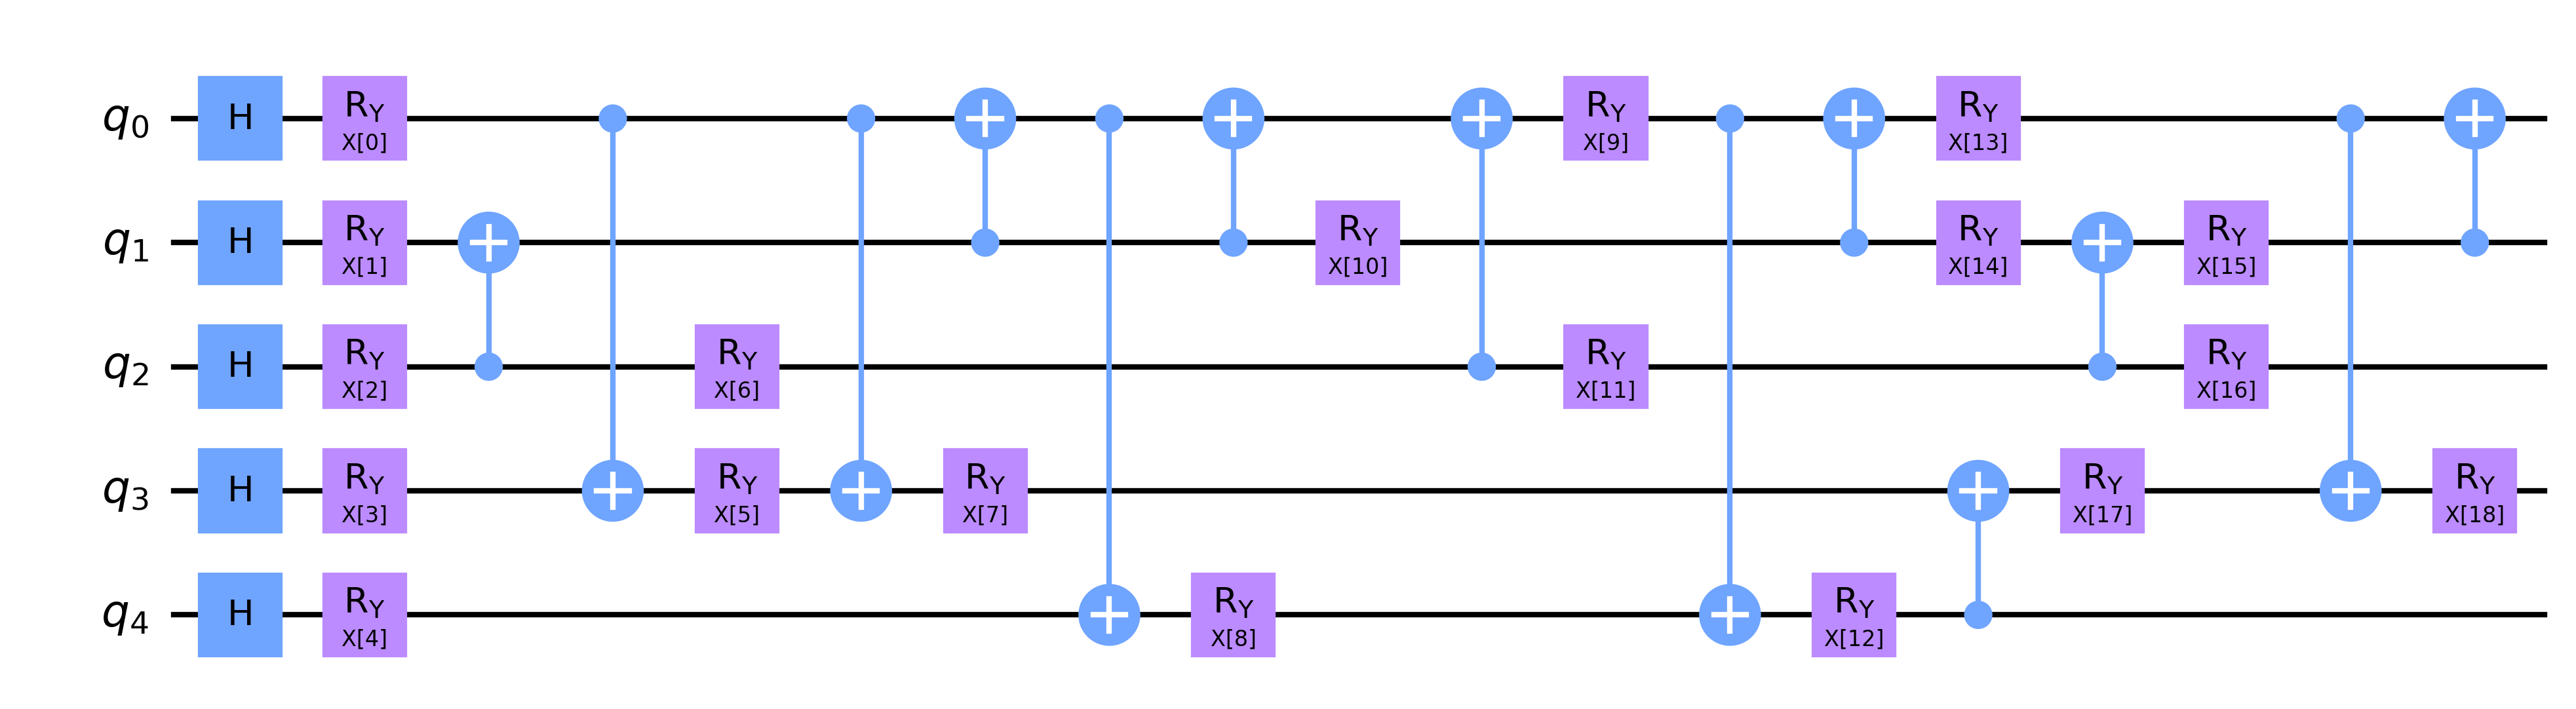

In [188]:
print(best_circs[-1])
print(best_vals)
# plt.plot(best_vals)
best_depths = list(map(lambda c: build_circuit(c, add_rs=False, add_h=True).depth(), best_circs))
print(best_depths)
best_num_params = list(map(lambda c: build_circuit(c, add_rs=False, add_h=True).num_parameters, best_circs))
print(best_num_params)
# print(build_circuit(best_circs[-1]))
qc = build_circuit(best_circs[-1], add_rs=False, add_h=True)
print(qc.depth())
qc.draw(output='mpl')

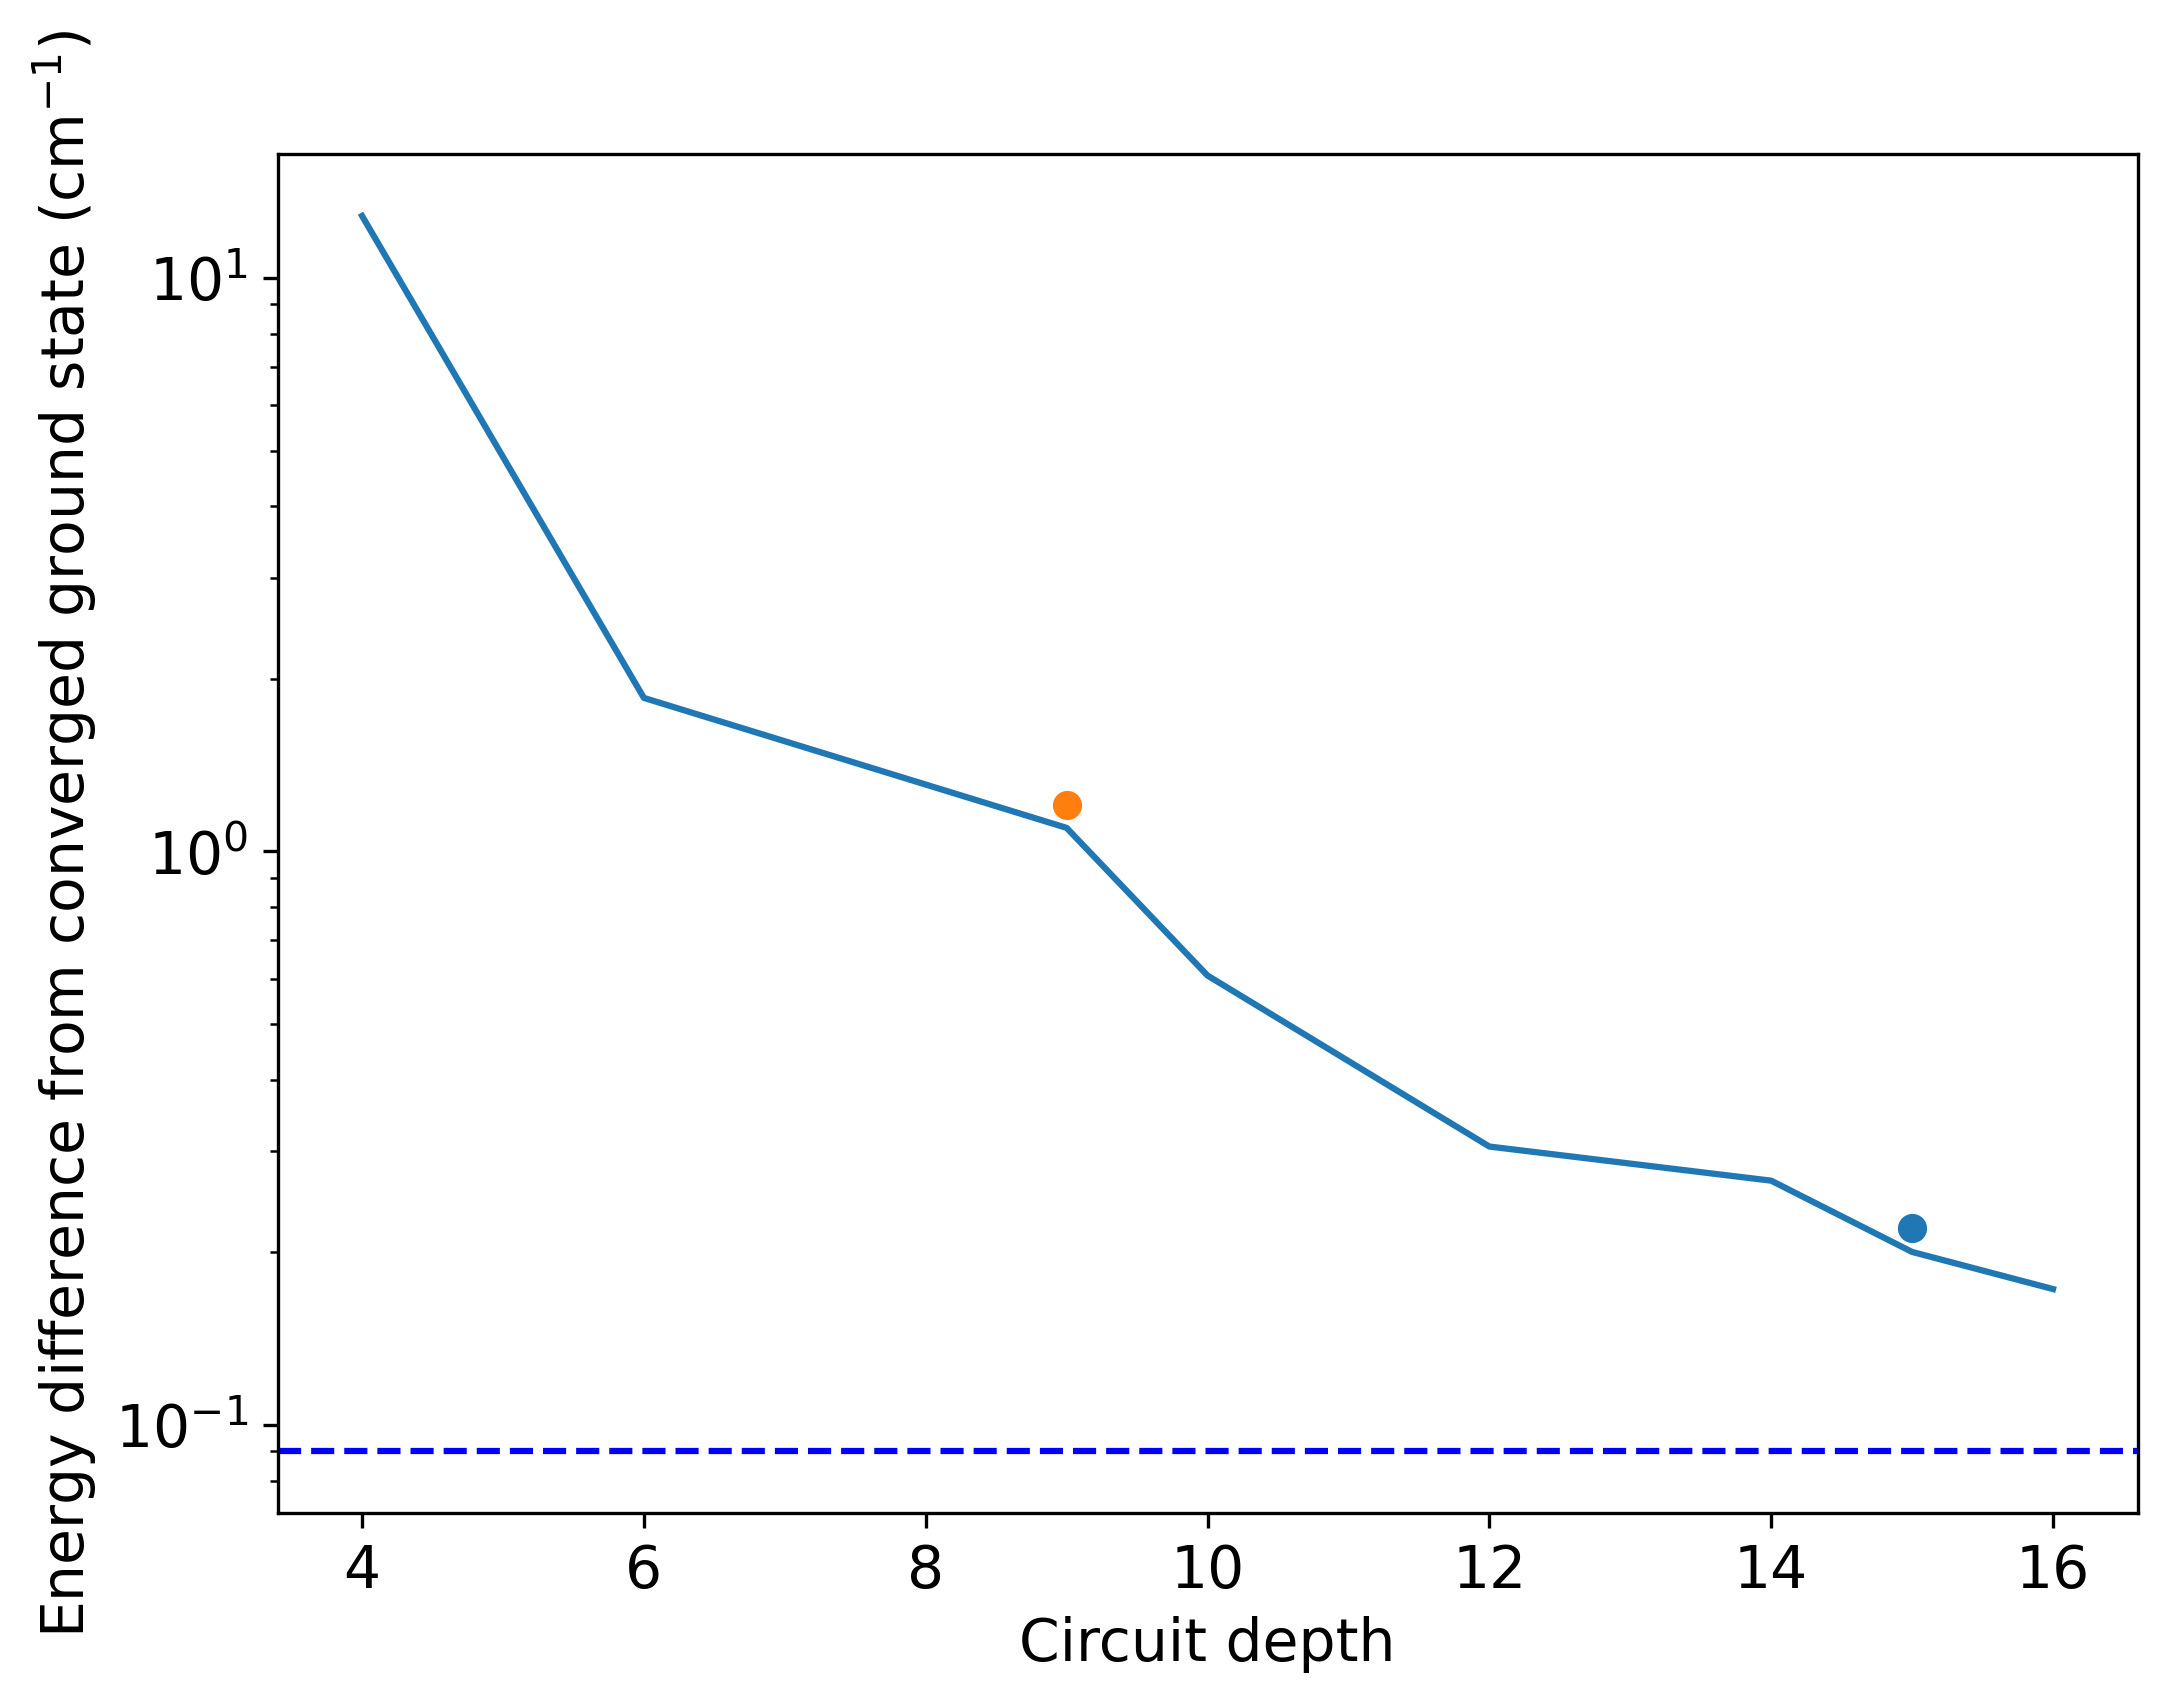

In [183]:
ref = -115.26788457220933
plt.plot(best_depths, abs(ref - np.array(best_vals)))
plt.scatter(15, 0.22017660276553386)
plt.scatter(9, 1.2068774694549376)
plt.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
plt.xlabel('Circuit depth')
plt.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# plt.title('Energy convergence for various optimizers')
plt.yscale('log')

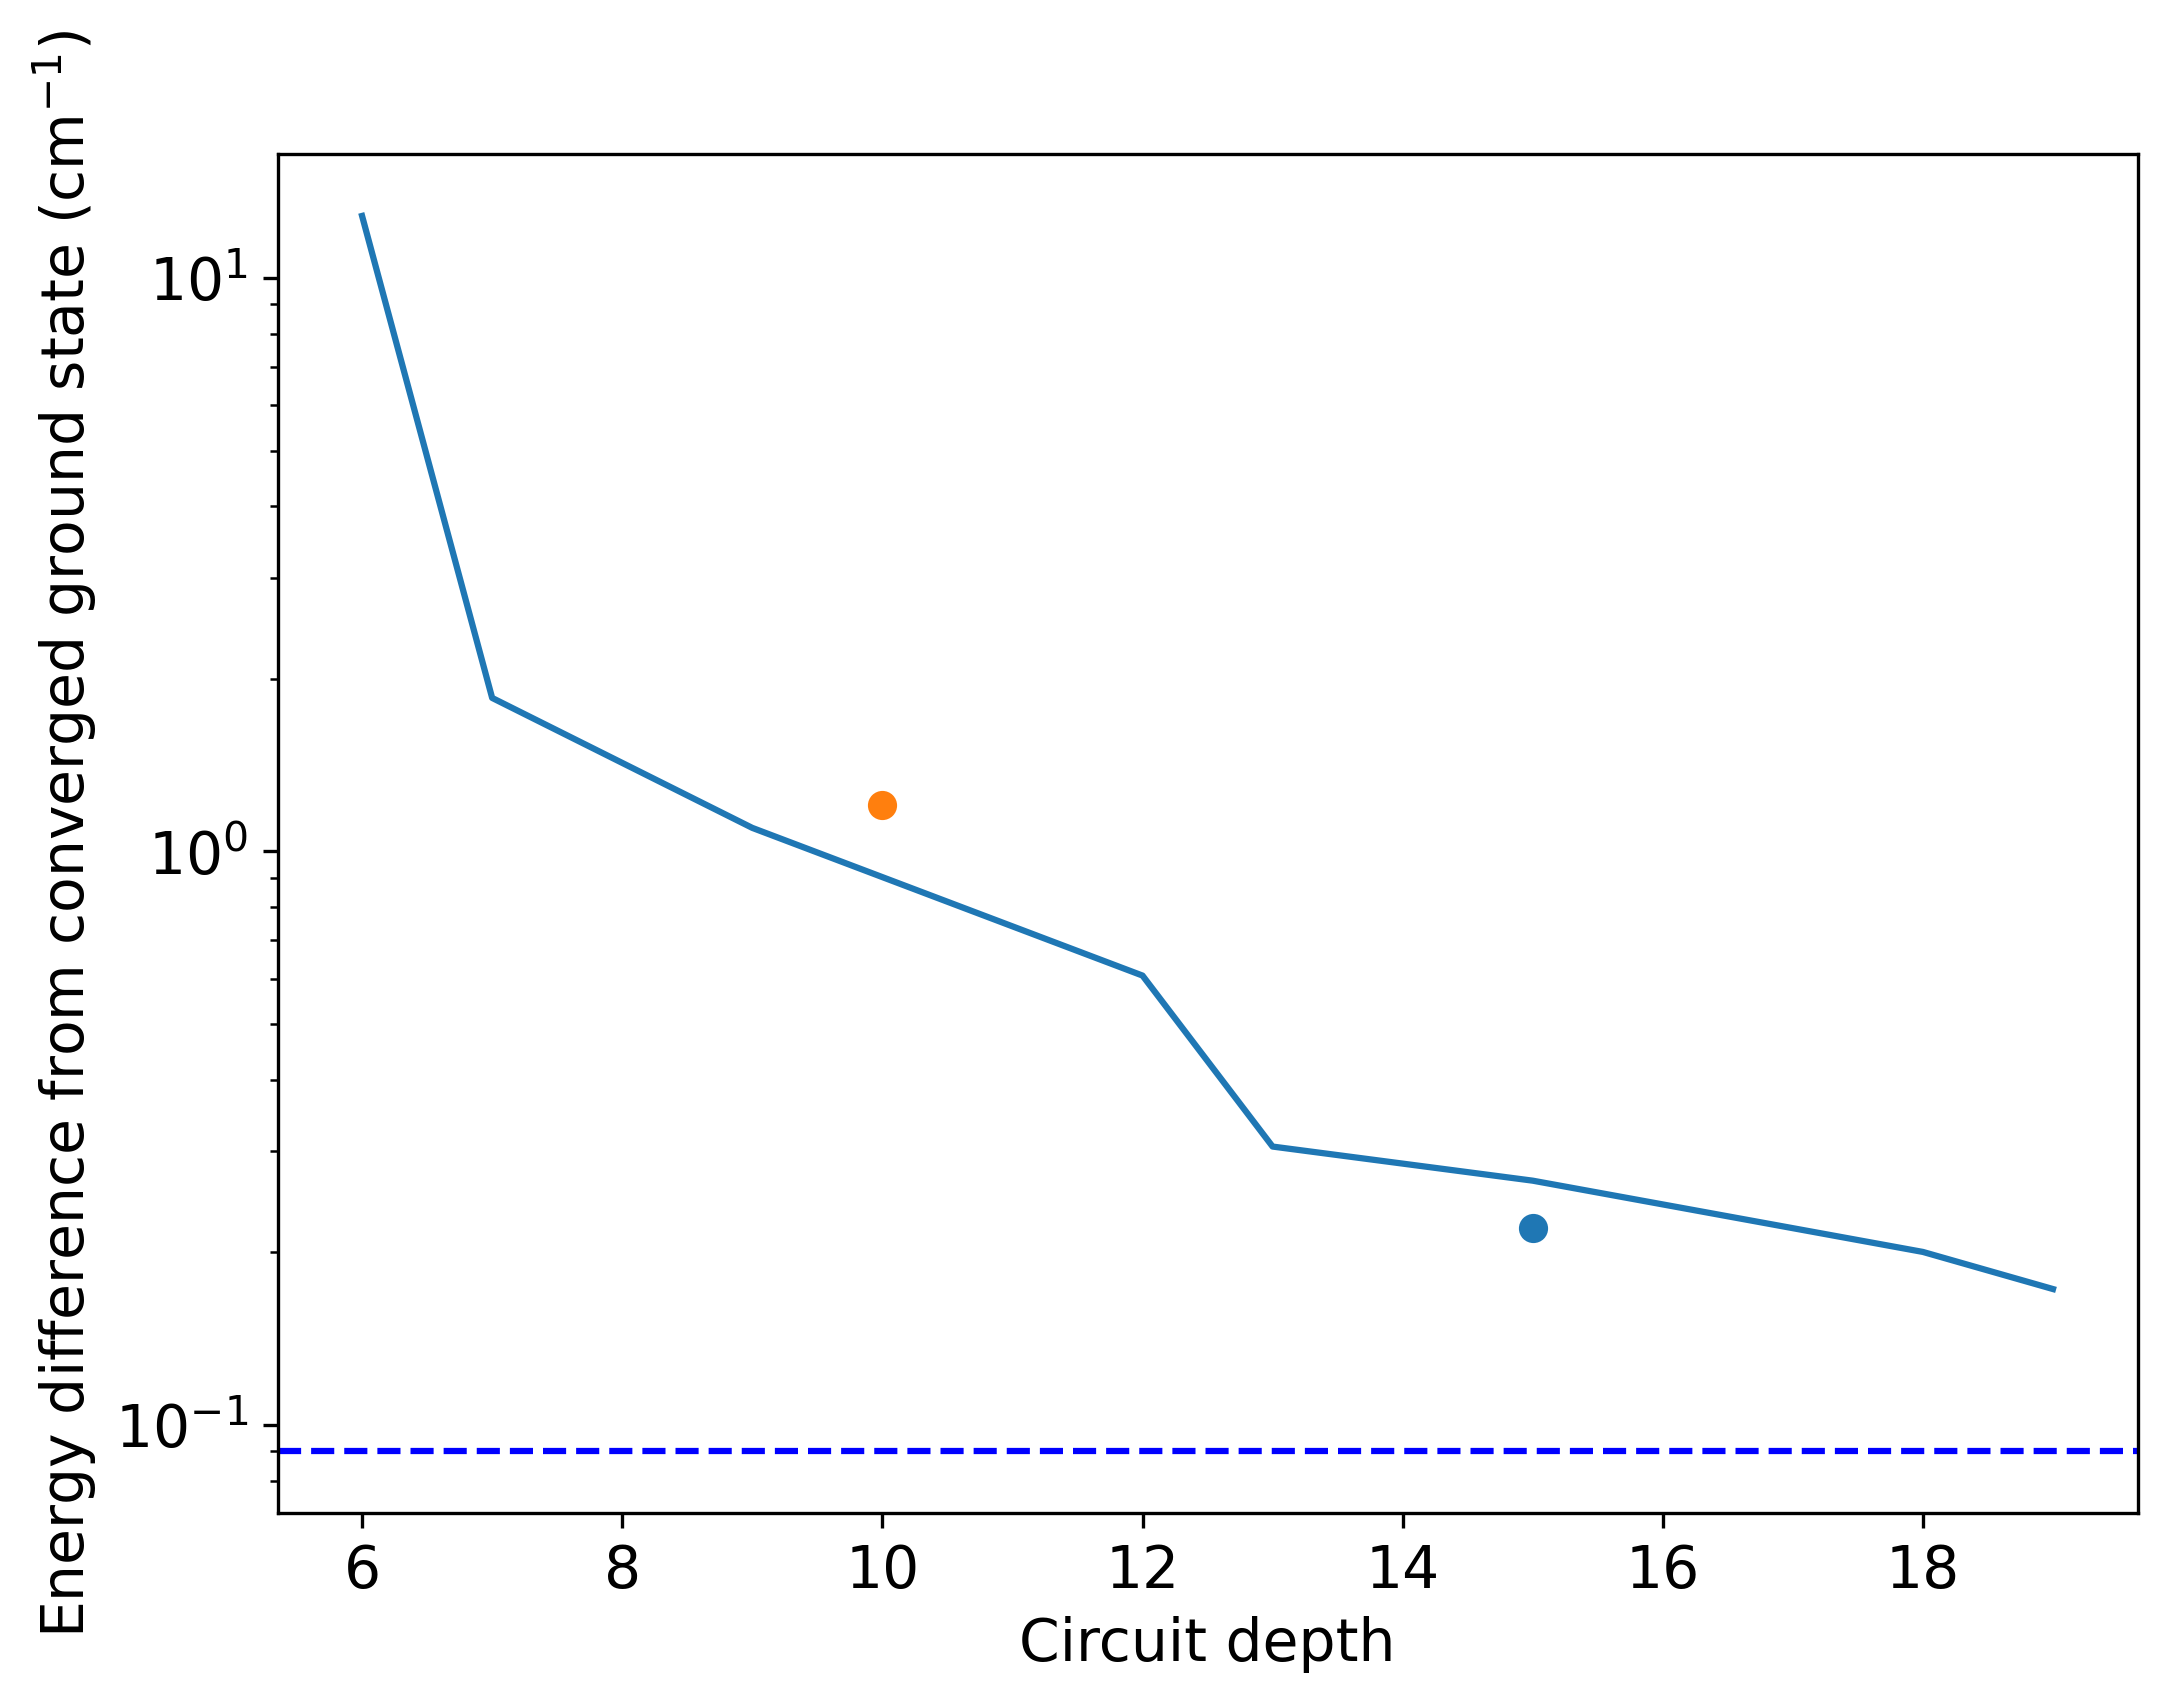

In [186]:
ref = -115.26788457220933
plt.plot(best_num_params, abs(ref - np.array(best_vals)))
plt.scatter(15, 0.22017660276553386)
plt.scatter(10, 1.2068774694549376)
plt.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
plt.xlabel('Circuit depth')
plt.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# plt.title('Energy convergence for various optimizers')
plt.yscale('log')

COBYLA -115.02454256355168 0.243342008657649
L_BFGS_B -115.04770818006652 0.22017639214280393
SLSQP -115.04770796944379 0.22017660276553386
NELDER_MEAD -114.99038449241573 0.27750007979359737
0.08991874864886995


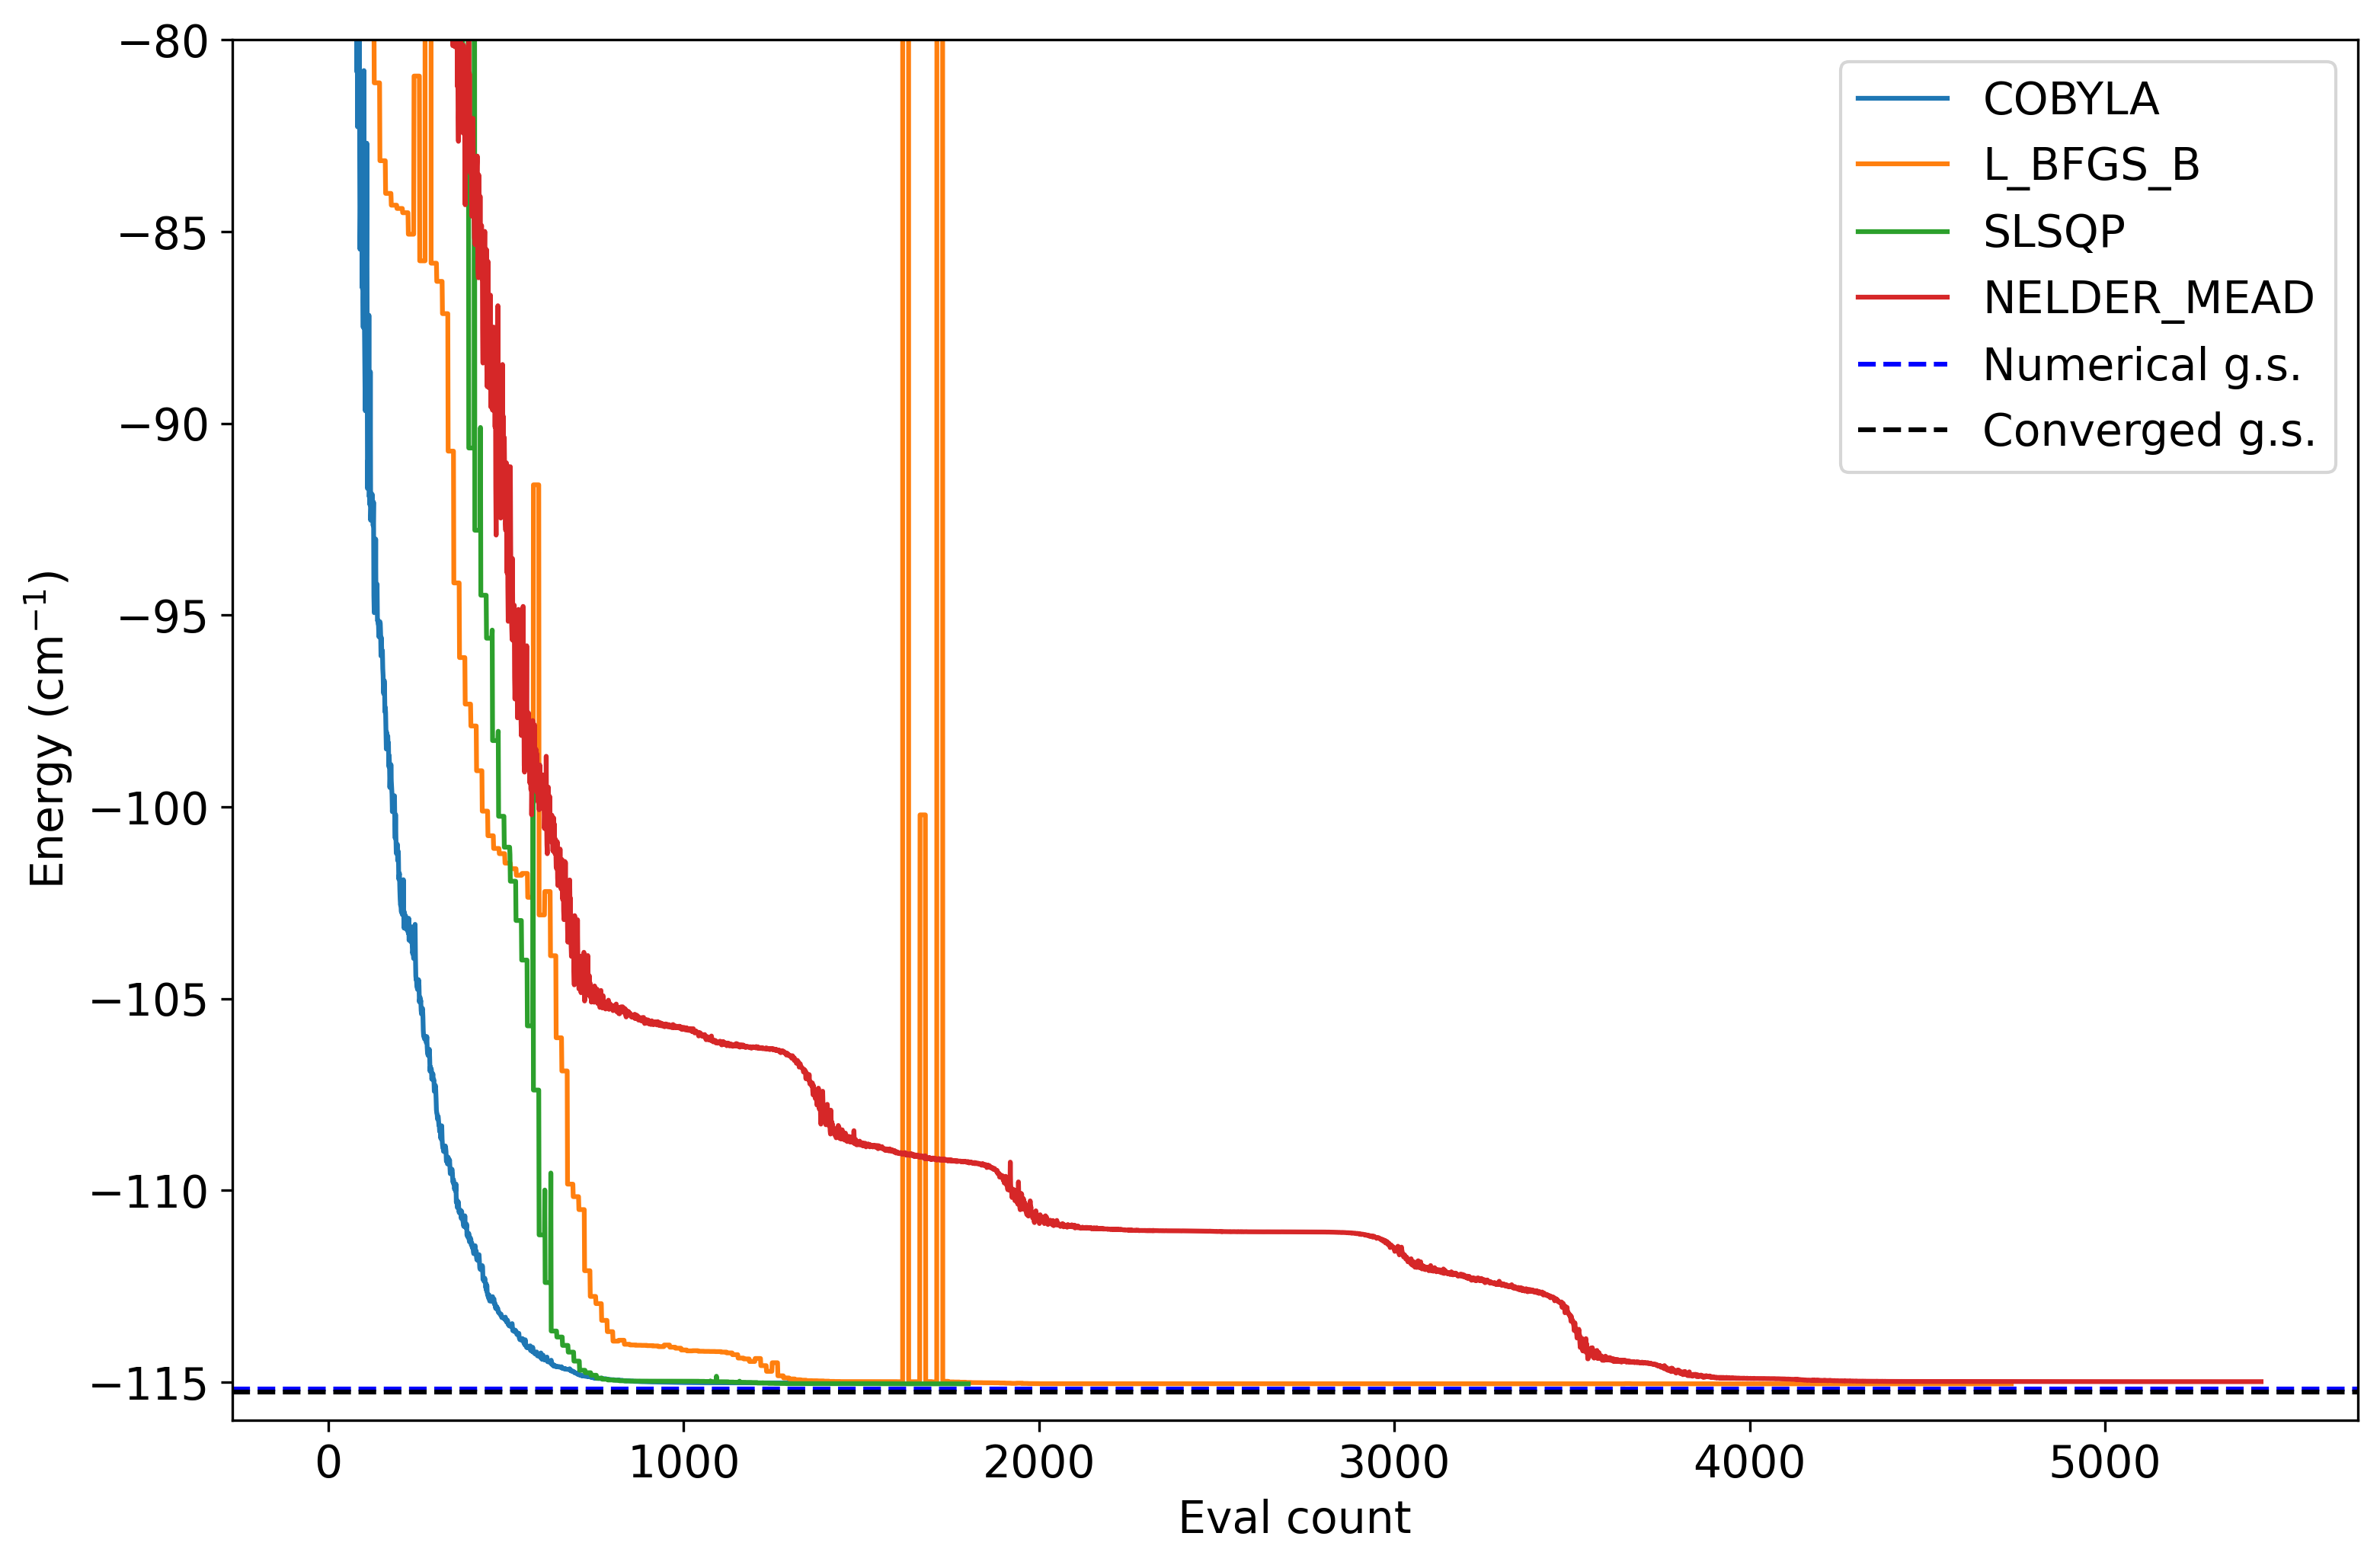

In [29]:
import pylab

ref = -115.26788457220933
# print(converge_cnts1, converge_vals1)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals1[i][-1], abs(ref - converge_vals1[i][-1]))
    pylab.plot(converge_cnts1[i], converge_vals1[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-116, -80)
pylab.legend(loc='upper right');

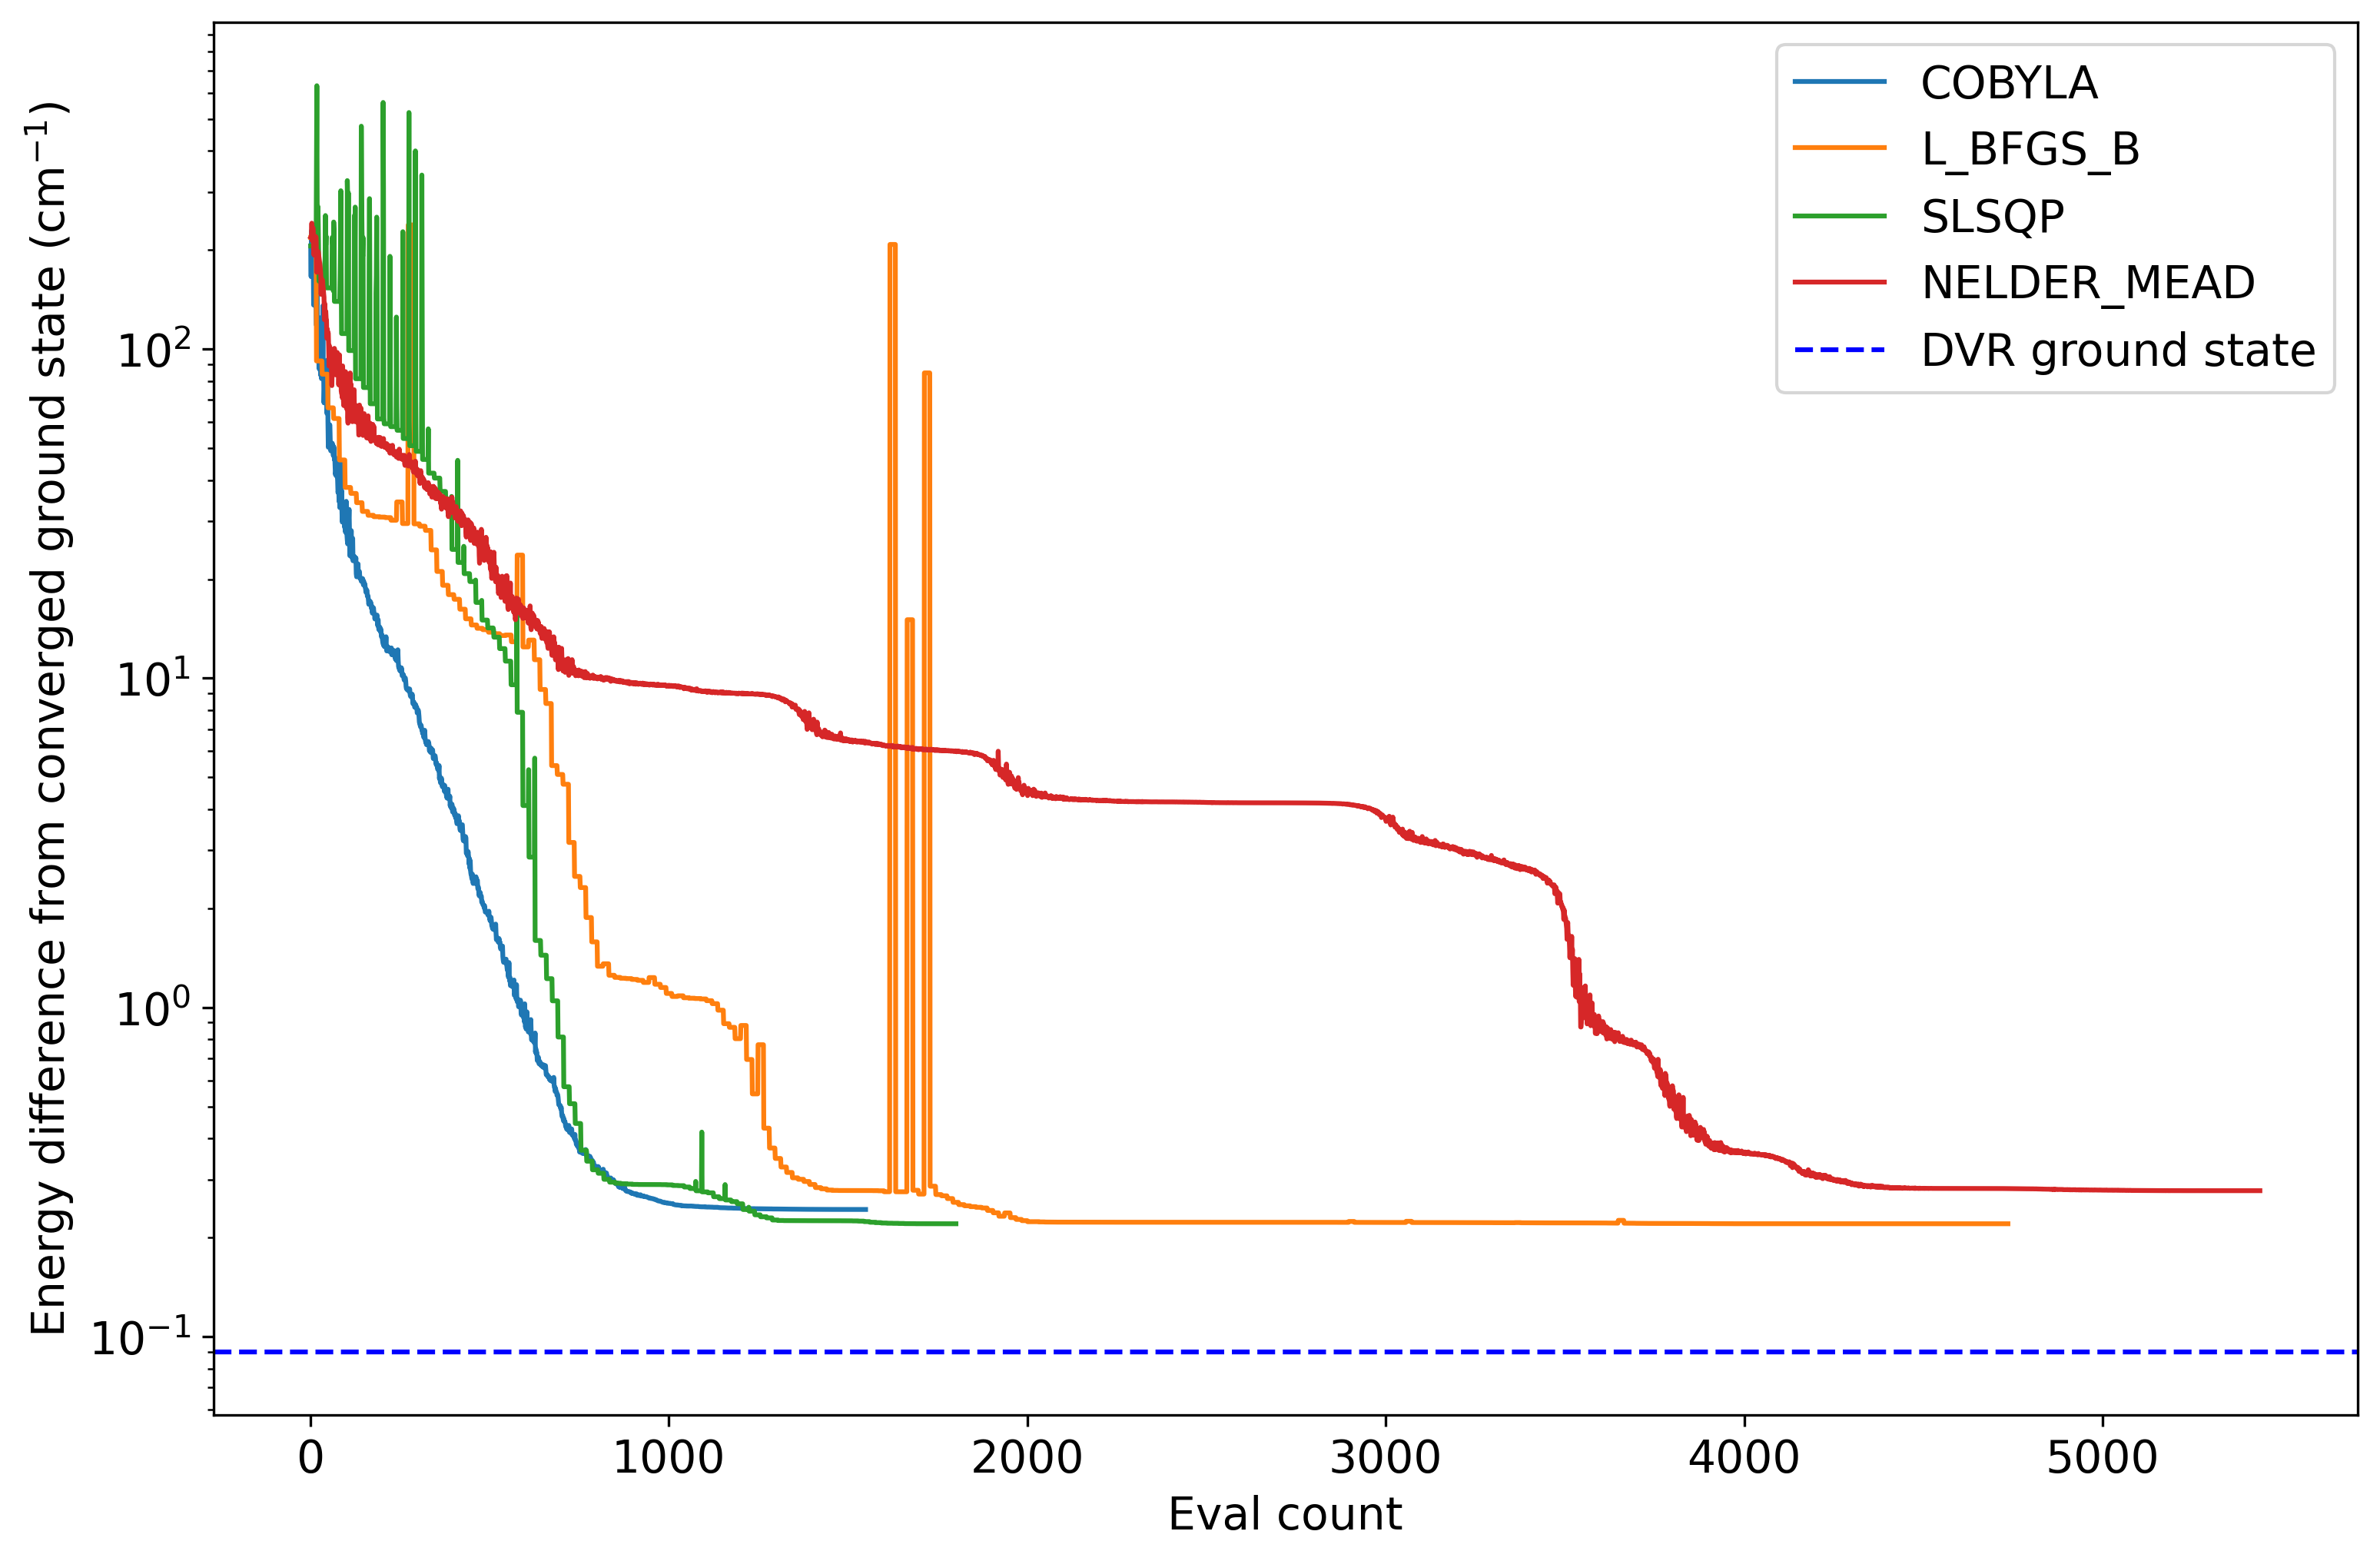

In [28]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

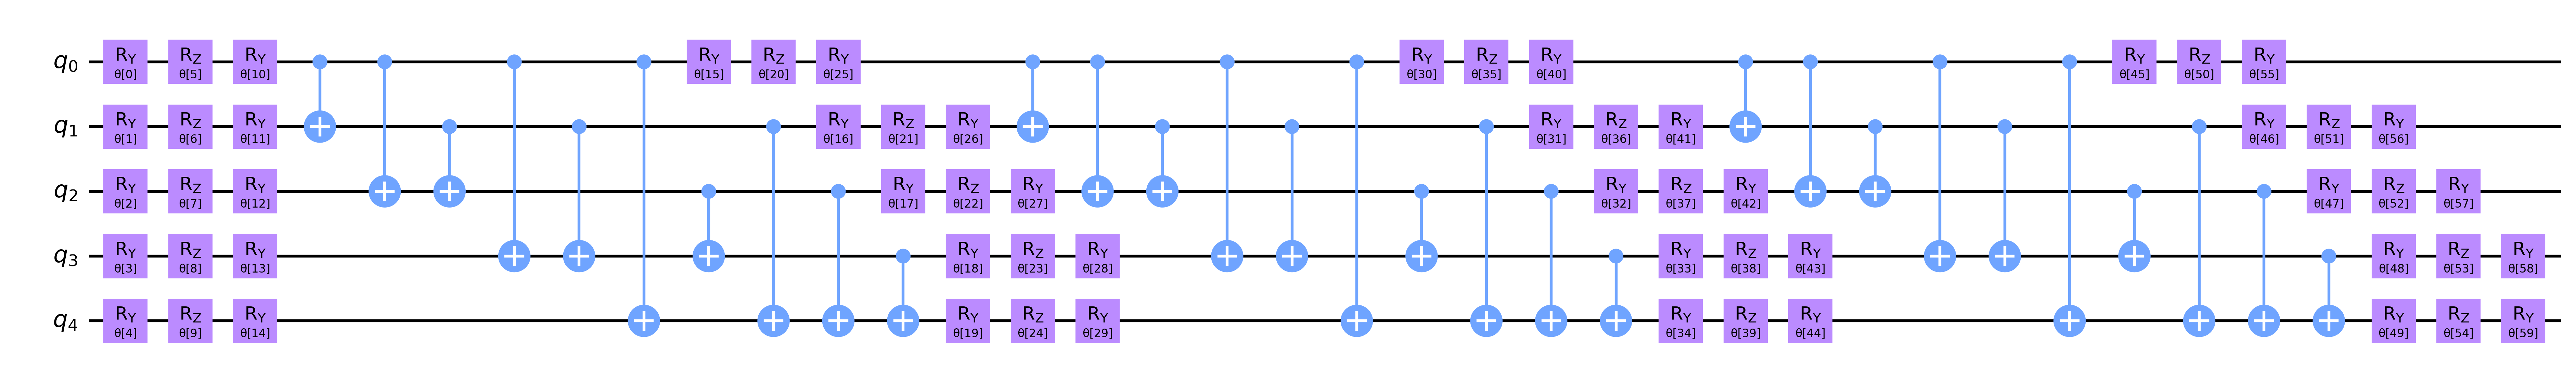

In [37]:
ansatz2 = TwoLocal(5, rotation_blocks=['ry', 'rz', 'ry'], entanglement_blocks='cx', entanglement='full', reps=3).decompose()
ansatz2.draw(output='mpl', fold=-1)
# print(ansatz)

In [38]:
h_dvr_pauli = pauli_decompose(h_dvr)

np.allclose(h_dvr, h_dvr_pauli.to_matrix())

print(h_dvr.shape)
print(h_dvr_pauli.coeffs.shape)
# print(h_dvr_pauli)

/Users/user/Library/CloudStorage/OneDrive-UBC/arc/root/project/dvr_vqe/2d/dvr2d.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


(32, 32)
(172,)


In [42]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts2 = np.empty([len(optimizers)], dtype=object)
converge_vals2 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res2 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz2, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res2 is None) or (values[-1] < best_res2):
            best_res2 = values[-1]
            converge_cnts2[i] = np.asarray(counts)
            converge_vals2[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
8000, -115.01637676646519
8000, -114.96394839197508
8000, -115.02419250542167
Optimizer: L_BFGS_B        
8052, -115.01814280183252
8052, -115.01846733129659
8052, -115.01941103664232
Optimizer: SLSQP        
40843, -115.16675604701412
12916, -115.10199289177774
18572, -115.10521754420786
Optimizer: NELDER_MEAD        
8000, -114.804227845114012
8000, -113.09279612551741
8000, -114.64011638884687

Optimization complete      


COBYLA -115.02419250542167 0.2436920667876592
L_BFGS_B -115.0194110366423 0.24847353556702956
SLSQP -115.10521754420786 0.16266702800146504
NELDER_MEAD -114.80422784511401 0.46365672709531225
0.08991874864886995


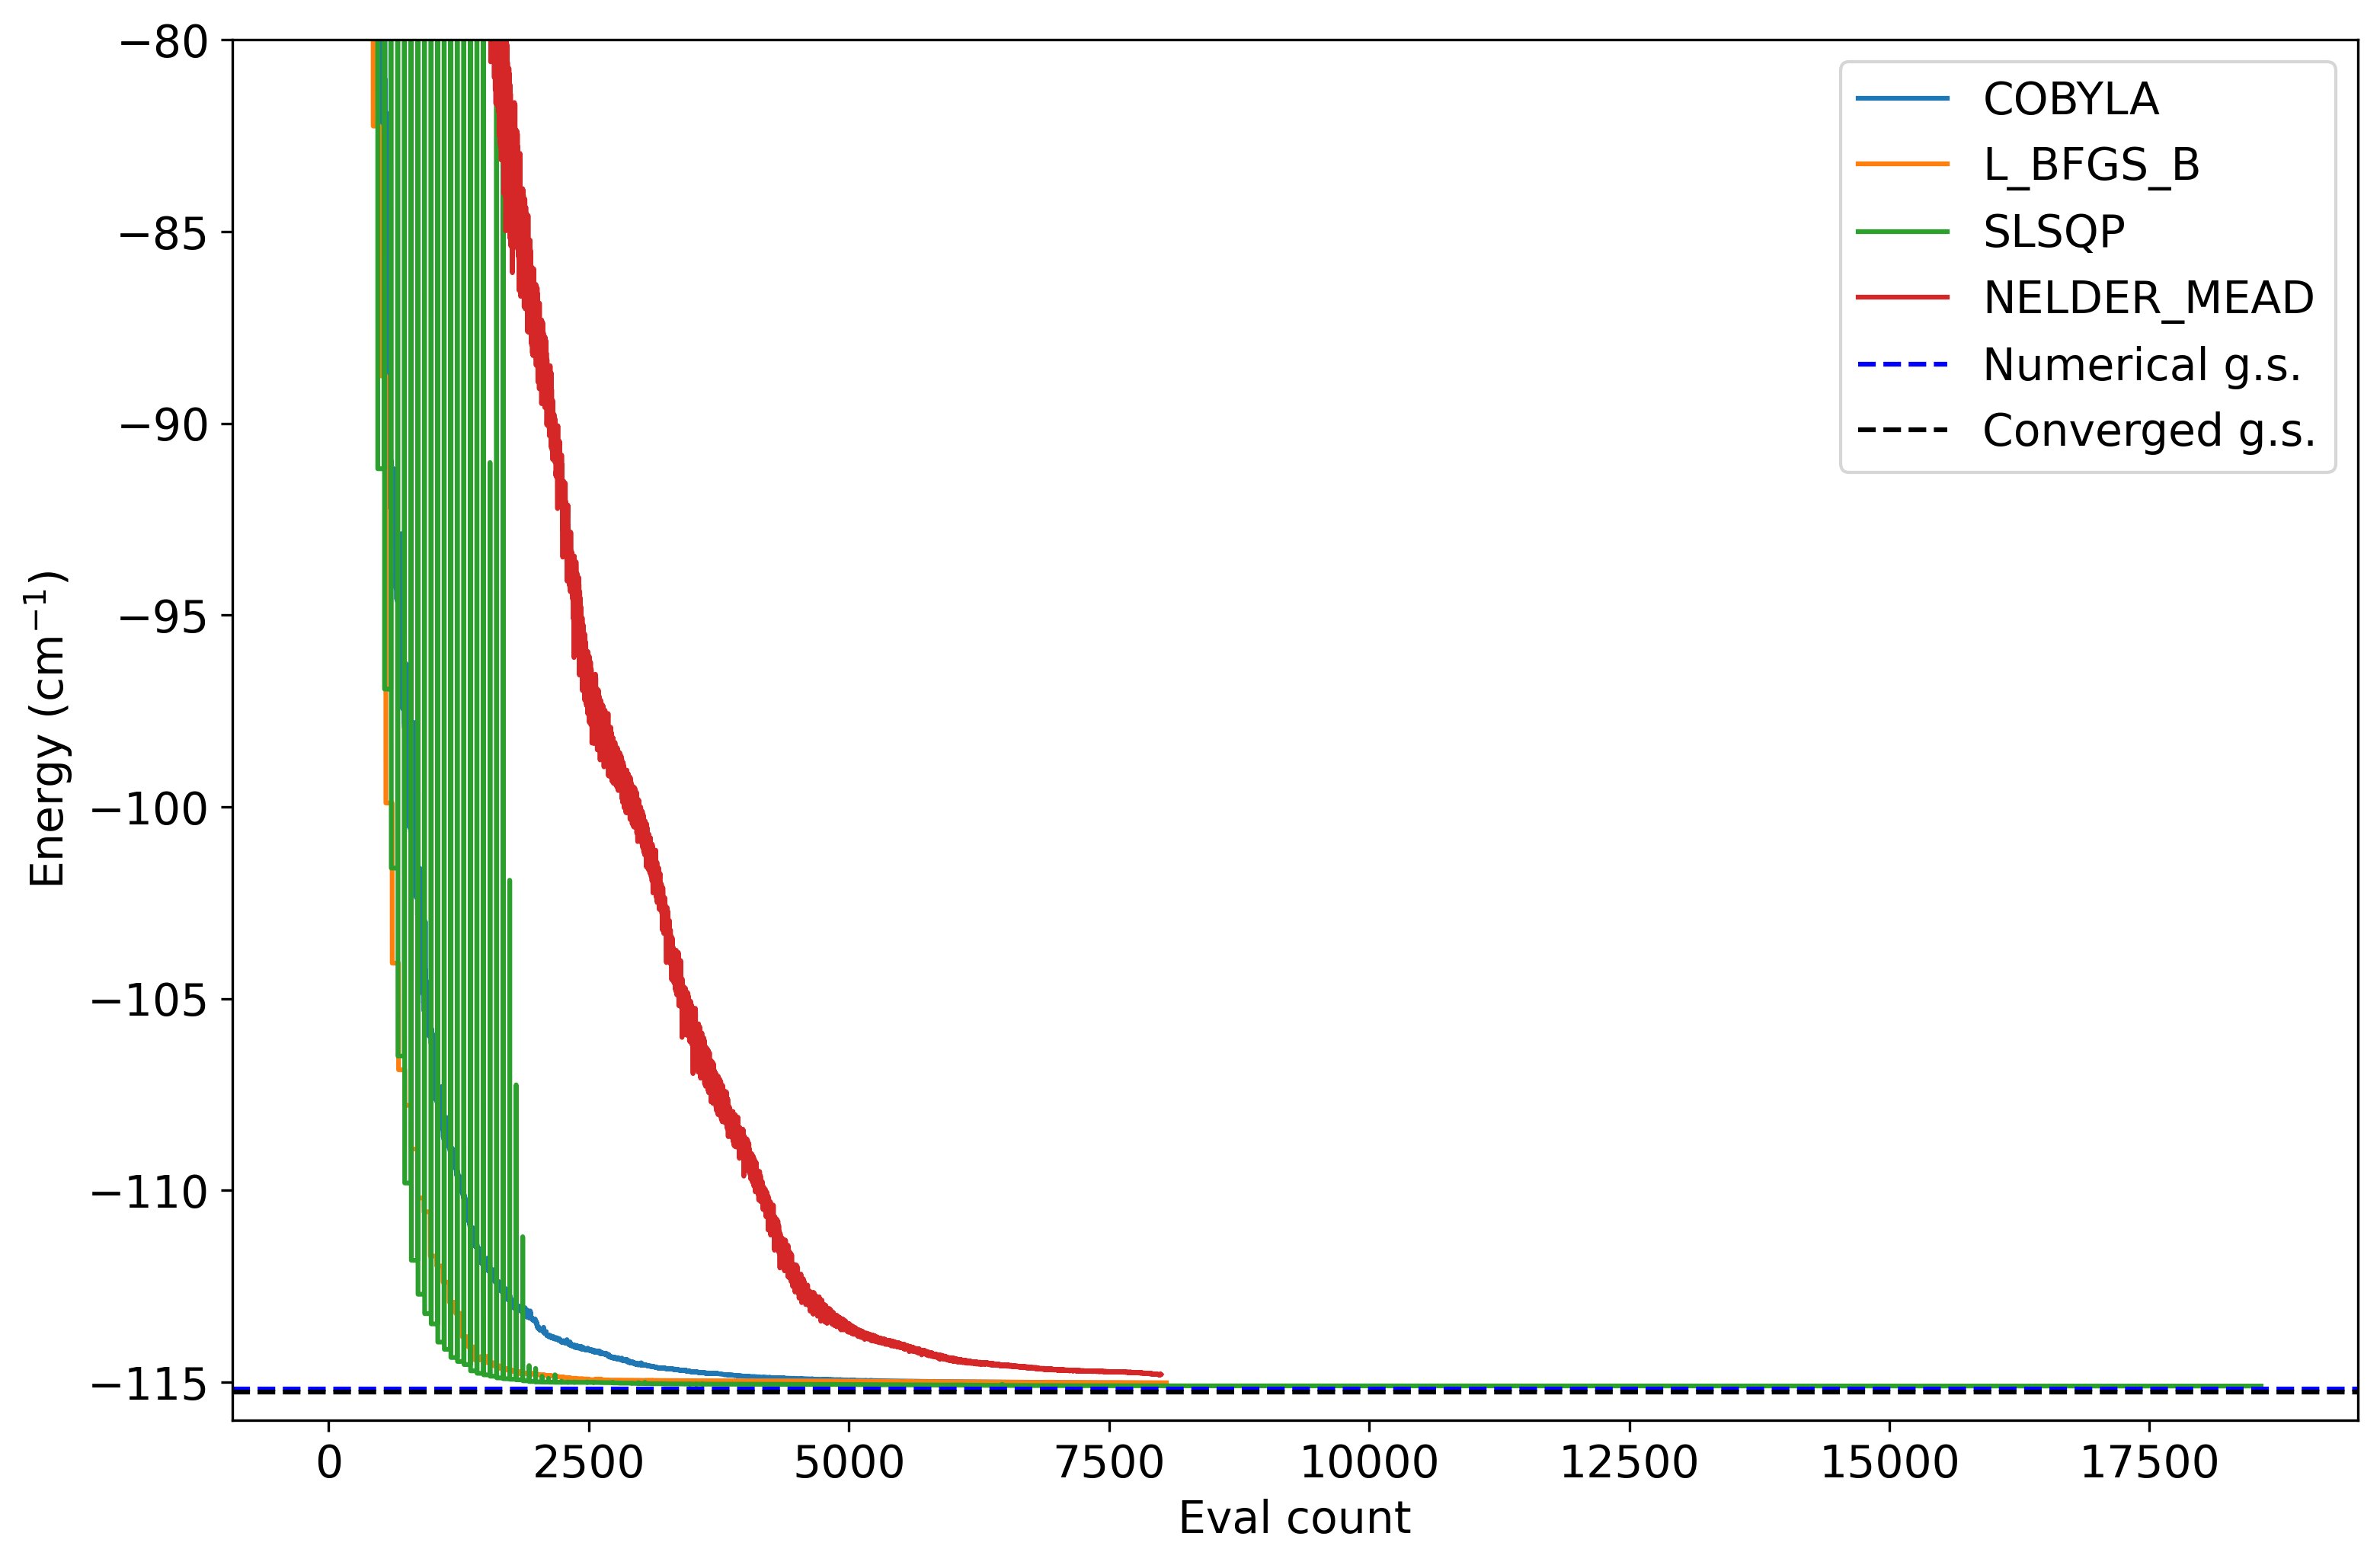

In [41]:
import pylab

ref = -115.26788457220933
# print(converge_cnts2, converge_vals2)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals2[i][-1], abs(ref - converge_vals2[i][-1]))
    pylab.plot(converge_cnts2[i], converge_vals2[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-116, -80)
pylab.legend(loc='upper right');

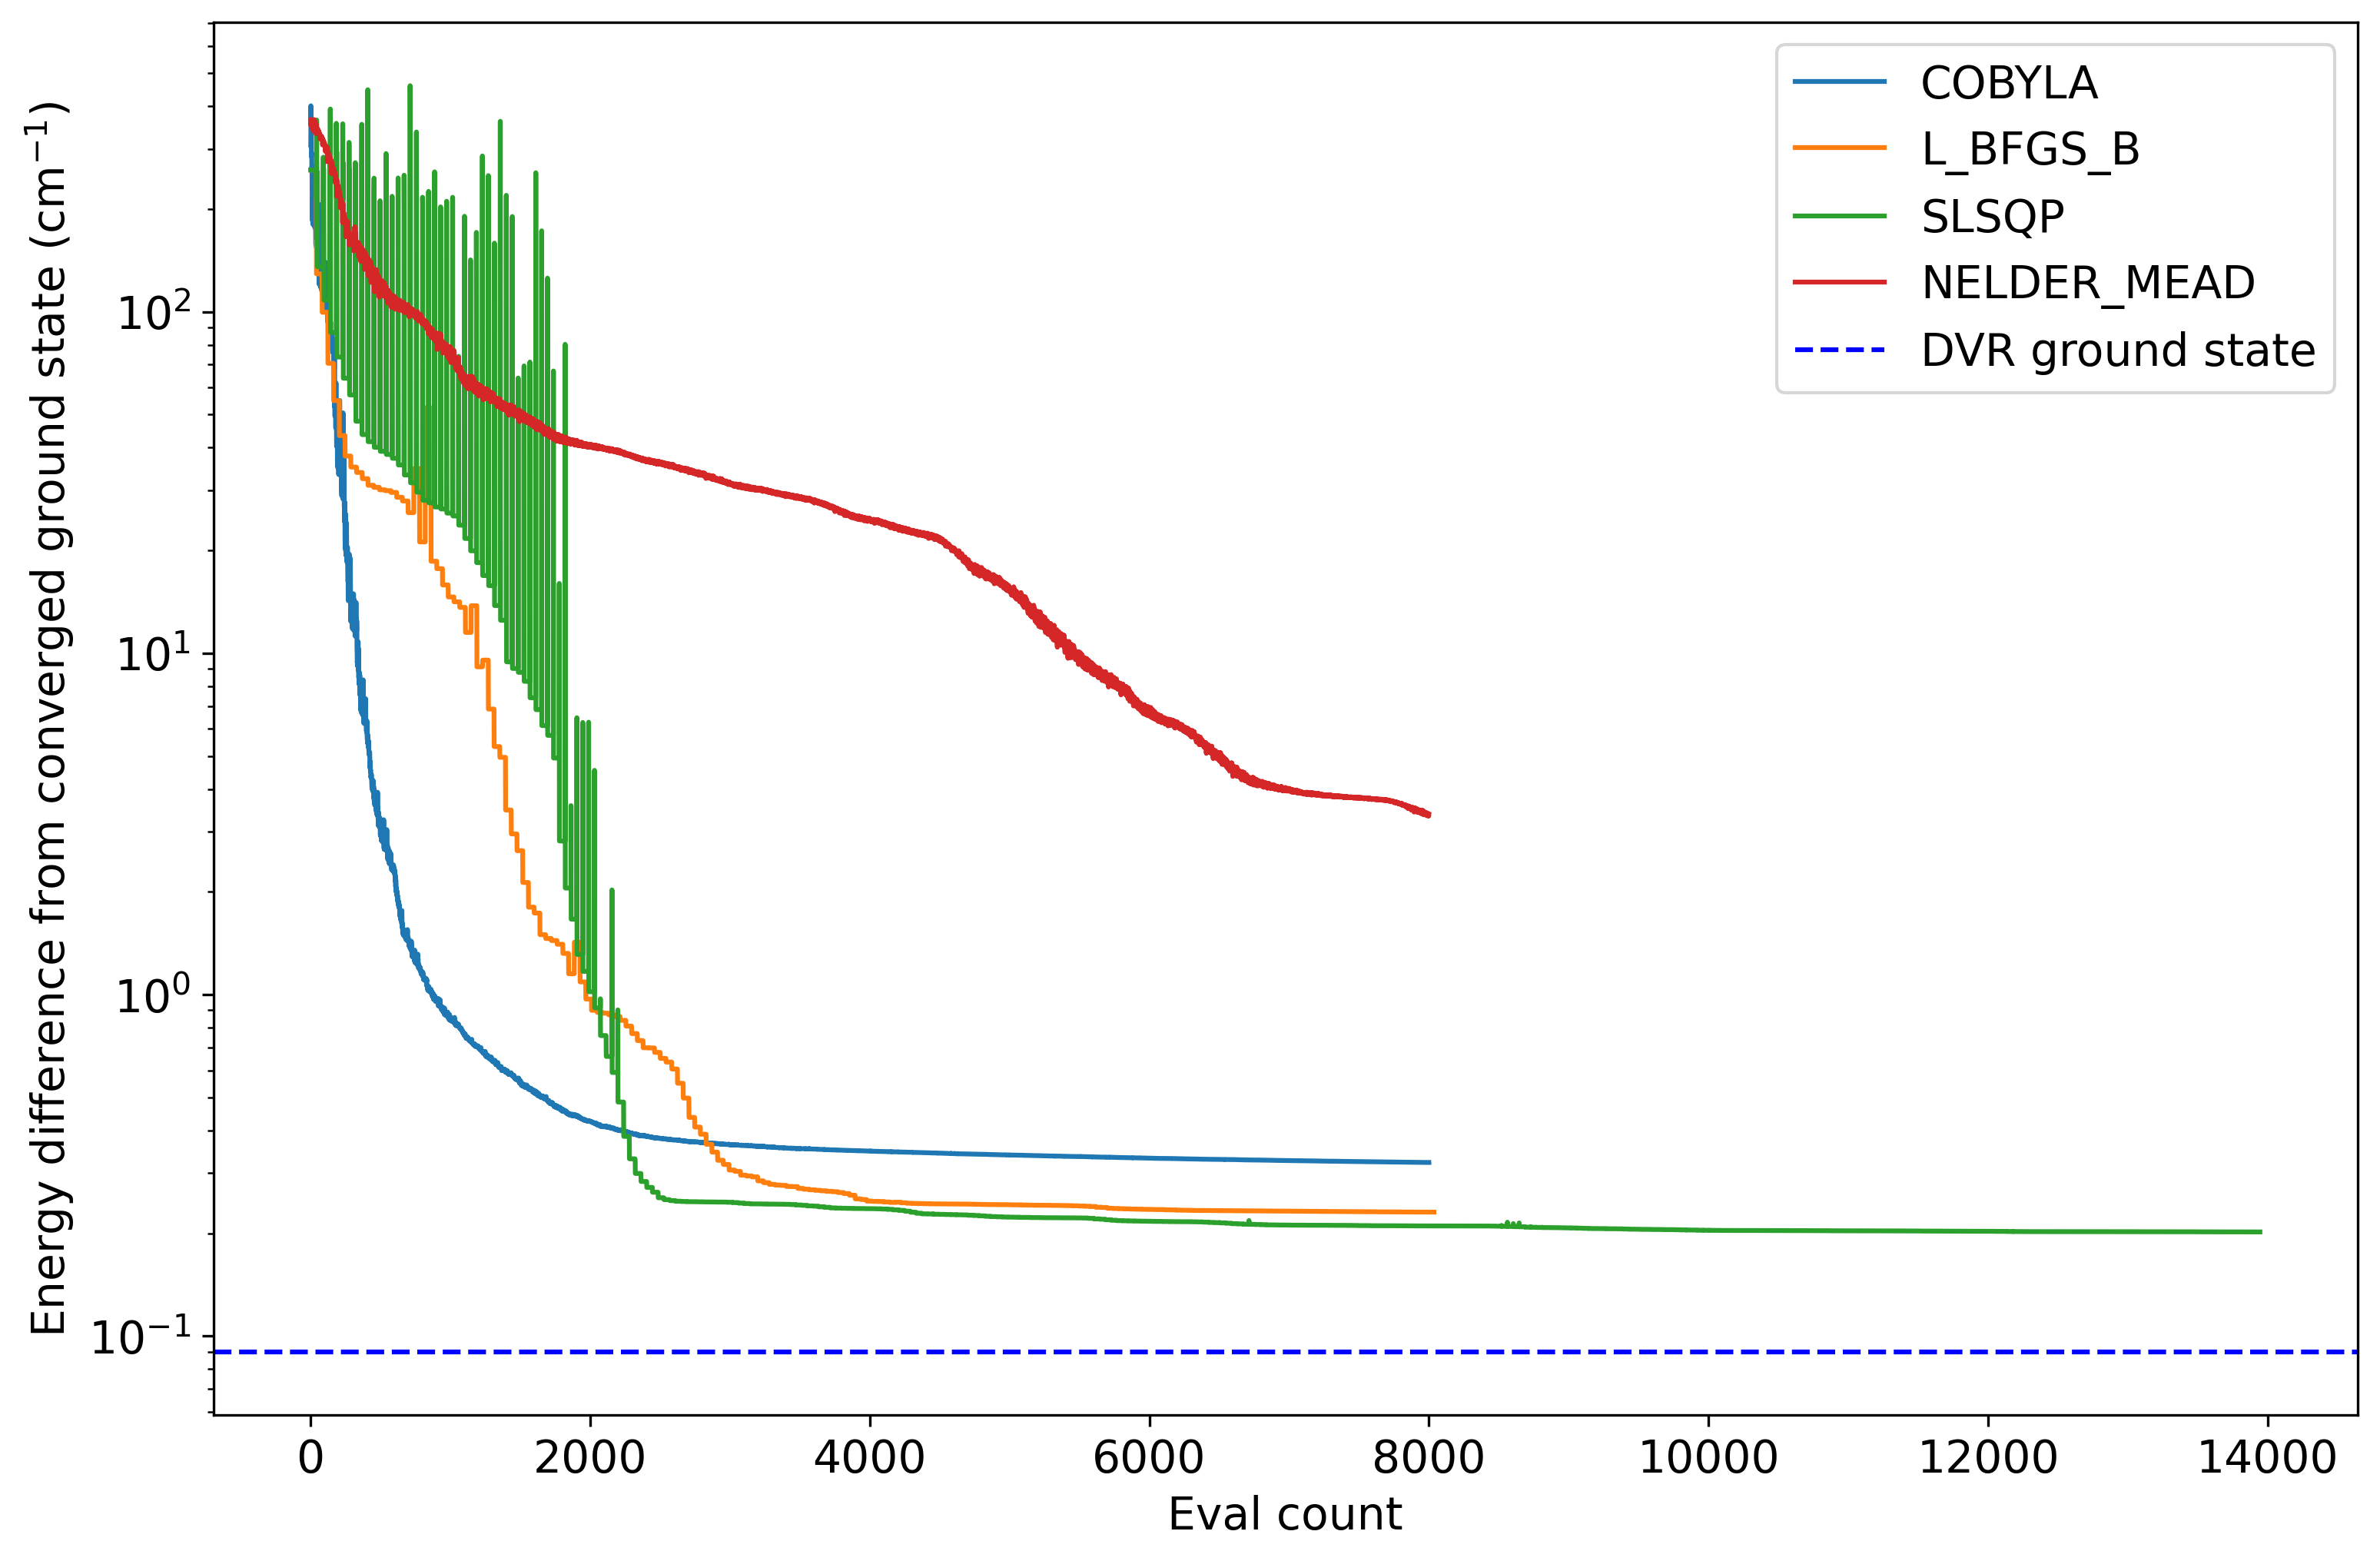

In [36]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts2[i][:], abs(ref - converge_vals2[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))